<a href="https://colab.research.google.com/github/busekoseoglu/Cat_Dog_Classification/blob/main/Cat_Dog_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install visualkeras optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 21.5 MB/s 
     |████████████████████████████████| 992 kB 68.6 MB/s 
     |████████████████████████████████| 210 kB 77.9 MB/s 
     |████████████████████████████████| 81 kB 13.0 MB/s 
     |████████████████████████████████| 78 kB 9.1 MB/s 
     |████████████████████████████████| 147 kB 78.6 MB/s 
     |████████████████████████████████| 50 kB 8.4 MB/s 
     |████████████████████████████████| 112 kB 73.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=cef4a53a9b0ad7160a908d60ea2ef33b6d8864d3d249f65f7744c4aaeaba47c9
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Uninstalling importlib-metadata-5.1.0:
      

In [2]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
%cd /content/gdrive/MyDrive/Projelerim/Huawei Image Classification

/content/gdrive/MyDrive/Projelerim/Huawei Image Classification


In [6]:
%ls

'Cat-Dog Sınıflandırma.ipynb'   test_set/   training_set/


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

import visualkeras

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

import optuna
import time

In [8]:
img_height, img_width =(300, 300)
batch_size=32

train_data_dir = "training_set"
test_data_dir = "test_set"

#horizontal_flip=True, width_shift_range=0.05,height_shift_range=0.05
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen=ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir,batch_size=batch_size, class_mode='categorical',target_size=(300, 300))     
test_generator =  test_datagen.flow_from_directory(test_data_dir,batch_size=batch_size, class_mode='categorical',target_size = (300, 300))                                                


Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [9]:
NUM_CLASSES = 2
BATCH_SIZE = 16
EPOCHS = 100

# Model 1

In [ ]:
model1 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.LeakyReLU(alpha=0.3),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.LeakyReLU(alpha=0.3),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
    ])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.

model1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"])

history = model1.fit(train_generator,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=test_generator,
                      callbacks=[callback],
                      shuffle=True)

Epoch 1/100
50/50 [==============================] - 17s 331ms/step - loss: 1.0849 - accuracy: 0.5006 - val_loss: 0.6924 - val_accuracy: 0.5700
Epoch 2/100
50/50 [==============================] - 11s 216ms/step - loss: 0.6899 - accuracy: 0.5581 - val_loss: 0.6868 - val_accuracy: 0.5700
Epoch 3/100
50/50 [==============================] - 11s 215ms/step - loss: 0.6607 - accuracy: 0.6169 - val_loss: 0.6753 - val_accuracy: 0.5950
Epoch 4/100
50/50 [==============================] - 11s 215ms/step - loss: 0.5262 - accuracy: 0.7425 - val_loss: 0.6768 - val_accuracy: 0.6275
Epoch 5/100
50/50 [==============================] - 11s 213ms/step - loss: 0.3672 - accuracy: 0.8556 - val_loss: 0.7389 - val_accuracy: 0.6025
Epoch 6/100
50/50 [==============================] - 12s 234ms/step - loss: 0.2278 - accuracy: 0.9225 - val_loss: 0.9167 - val_accuracy: 0.6050


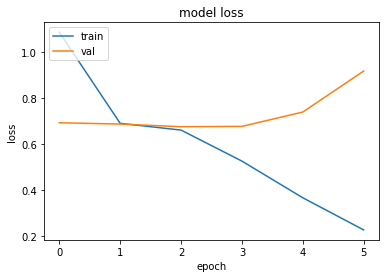

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

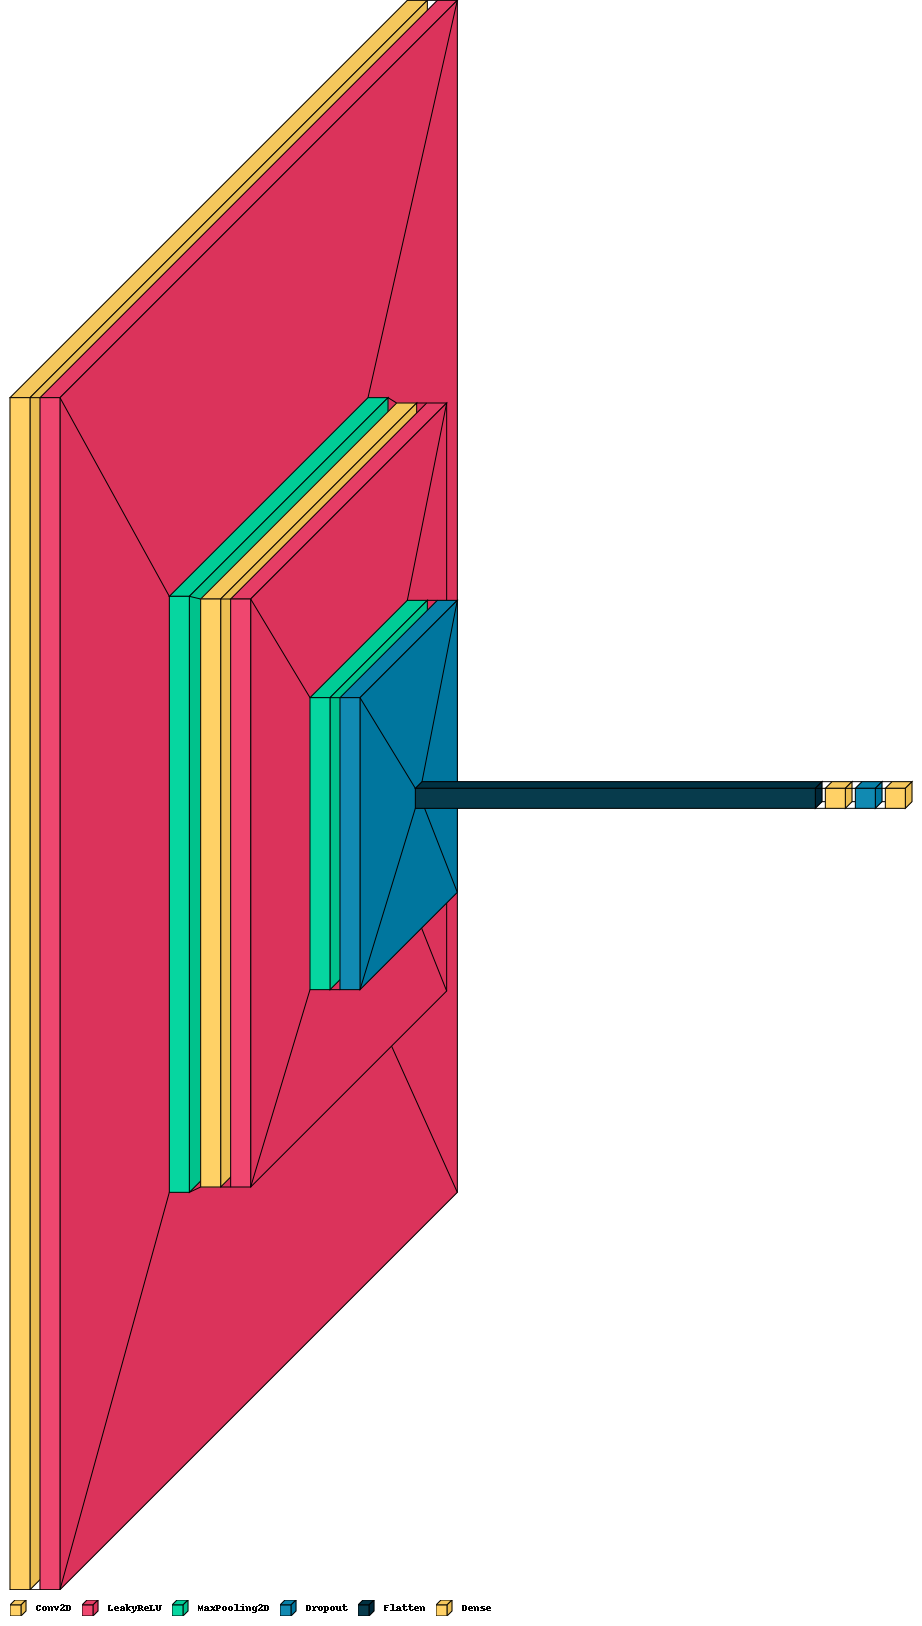

In [ ]:
visualkeras.layered_view(model1,legend=True, draw_volume=True)

## 5 Fold Cross Validation with Optuna (Model 1)

In [ ]:
n_train_iter = 1
def objective(trial):
    # Parameters
    batch_size = trial.suggest_int("batch_size", 2, 8, step=2)
    epochs = trial.suggest_int("epochs", 10,50, step=10)
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    opt = trial.suggest_categorical("optimizer", [Adam, SGD, RMSprop])

    # Model
    model1 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.LeakyReLU(alpha=0.3),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.LeakyReLU(alpha=0.3),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
    ])
    for step in range(n_train_iter):
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
        model1.compile(optimizer=opt(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
        H = model1.fit(train_generator,batch_size=batch_size,callbacks=[callback],
                epochs=epochs,validation_data=test_generator,shuffle=True)
        
        val_loss, val_acc = model1.evaluate(test_generator)
        trial.report(val_acc, step)

        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return val_loss # optuna değerlendirmesini en küçük değere göre yapıyor o yüzden loss döndürdüm. Accuracy döndürdüğümde acc büyüdükçe bunu kötü bir şeymiş gibi algıladı.


# Default Sampler is Tree-structured Parzen Estimator algorithm

study = optuna.create_study()  # Create a new study.
start = time.time()
study.optimize(objective, n_trials=5)
end = time.time()

[I 2022-12-25 11:35:34,620] A new study created in memory with name: no-name-90af2c92-b3c6-4418-aebb-3d87f9380a74


Epoch 1/40
50/50 [==============================] - 11s 220ms/step - loss: 0.6938 - accuracy: 0.5156 - val_loss: 0.6874 - val_accuracy: 0.5375
Epoch 2/40
50/50 [==============================] - 12s 241ms/step - loss: 0.6937 - accuracy: 0.5288 - val_loss: 0.6859 - val_accuracy: 0.5475
Epoch 4/40
50/50 [==============================] - 11s 214ms/step - loss: 0.6887 - accuracy: 0.5250 - val_loss: 0.6844 - val_accuracy: 0.5525
Epoch 5/40
50/50 [==============================] - 11s 212ms/step - loss: 0.6876 - accuracy: 0.5437 - val_loss: 0.6873 - val_accuracy: 0.5400
Epoch 6/40
50/50 [==============================] - 11s 212ms/step - loss: 0.6894 - accuracy: 0.5306 - val_loss: 0.6839 - val_accuracy: 0.5450
Epoch 7/40
50/50 [==============================] - 11s 212ms/step - loss: 0.6869 - accuracy: 0.5412 - val_loss: 0.6820 - val_accuracy: 0.5625
Epoch 8/40
50/50 [==============================] - 11s 211ms/step - loss: 0.6865 - accuracy: 0.5494 - val_loss: 0.6827 - val_accuracy: 0.5400

[I 2022-12-25 11:42:53,487] Trial 0 finished with value: 0.6602802276611328 and parameters: {'batch_size': 8, 'epochs': 40, 'learning_rate': 9.509560981225496e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}. Best is trial 0 with value: 0.6602802276611328.


Epoch 1/20
50/50 [==============================] - 11s 214ms/step - loss: 0.6935 - accuracy: 0.5231 - val_loss: 0.6924 - val_accuracy: 0.5325
Epoch 2/20
50/50 [==============================] - 11s 211ms/step - loss: 0.6914 - accuracy: 0.5288 - val_loss: 0.6838 - val_accuracy: 0.5625
Epoch 3/20
50/50 [==============================] - 11s 213ms/step - loss: 0.6858 - accuracy: 0.5475 - val_loss: 0.6811 - val_accuracy: 0.5850
Epoch 4/20
50/50 [==============================] - 11s 210ms/step - loss: 0.6777 - accuracy: 0.5700 - val_loss: 0.6797 - val_accuracy: 0.5800
Epoch 5/20
50/50 [==============================] - 11s 210ms/step - loss: 0.6810 - accuracy: 0.5738 - val_loss: 0.6817 - val_accuracy: 0.5550
Epoch 6/20
50/50 [==============================] - 11s 210ms/step - loss: 0.6770 - accuracy: 0.5744 - val_loss: 0.6746 - val_accuracy: 0.5850
Epoch 7/20
50/50 [==============================] - 11s 209ms/step - loss: 0.6705 - accuracy: 0.5838 - val_loss: 0.6697 - val_accuracy: 0.6050

[I 2022-12-25 11:46:05,893] Trial 1 finished with value: 0.6735613346099854 and parameters: {'batch_size': 4, 'epochs': 20, 'learning_rate': 0.0011985559962482651, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}. Best is trial 0 with value: 0.6602802276611328.


Epoch 1/30
50/50 [==============================] - 11s 216ms/step - loss: 0.7509 - accuracy: 0.5244 - val_loss: 0.6915 - val_accuracy: 0.5750
Epoch 2/30
50/50 [==============================] - 11s 212ms/step - loss: 0.6917 - accuracy: 0.5194 - val_loss: 0.6886 - val_accuracy: 0.5175
Epoch 3/30
50/50 [==============================] - 11s 212ms/step - loss: 0.6882 - accuracy: 0.5475 - val_loss: 0.6862 - val_accuracy: 0.5225
Epoch 4/30
50/50 [==============================] - 11s 212ms/step - loss: 0.6861 - accuracy: 0.5550 - val_loss: 0.6868 - val_accuracy: 0.5800
Epoch 5/30
50/50 [==============================] - 11s 211ms/step - loss: 0.6846 - accuracy: 0.5519 - val_loss: 0.6833 - val_accuracy: 0.5700
Epoch 6/30
50/50 [==============================] - 11s 210ms/step - loss: 0.6831 - accuracy: 0.5500 - val_loss: 0.6844 - val_accuracy: 0.5625
Epoch 7/30
50/50 [==============================] - 11s 212ms/step - loss: 0.6824 - accuracy: 0.5619 - val_loss: 0.6834 - val_accuracy: 0.5675

[I 2022-12-25 11:50:44,143] Trial 2 finished with value: 0.677811861038208 and parameters: {'batch_size': 4, 'epochs': 30, 'learning_rate': 3.559008603199205e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>}. Best is trial 0 with value: 0.6602802276611328.


Epoch 1/30
50/50 [==============================] - 11s 221ms/step - loss: 0.6962 - accuracy: 0.4931 - val_loss: 0.6957 - val_accuracy: 0.4950
Epoch 2/30
50/50 [==============================] - 10s 207ms/step - loss: 0.6921 - accuracy: 0.5312 - val_loss: 0.6949 - val_accuracy: 0.4975
Epoch 3/30
50/50 [==============================] - 10s 209ms/step - loss: 0.6939 - accuracy: 0.5250 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 4/30
50/50 [==============================] - 10s 209ms/step - loss: 0.6969 - accuracy: 0.4969 - val_loss: 0.6937 - val_accuracy: 0.5025
Epoch 5/30
50/50 [==============================] - 11s 212ms/step - loss: 0.6934 - accuracy: 0.5188 - val_loss: 0.6930 - val_accuracy: 0.5275
Epoch 6/30
50/50 [==============================] - 10s 208ms/step - loss: 0.6958 - accuracy: 0.5013 - val_loss: 0.6925 - val_accuracy: 0.5125
Epoch 7/30
50/50 [==============================] - 11s 210ms/step - loss: 0.6920 - accuracy: 0.5125 - val_loss: 0.6920 - val_accuracy: 0.5000

[I 2022-12-25 11:56:22,358] Trial 3 finished with value: 0.6847888231277466 and parameters: {'batch_size': 8, 'epochs': 30, 'learning_rate': 2.0591803081587497e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}. Best is trial 0 with value: 0.6602802276611328.


Epoch 1/50
50/50 [==============================] - 11s 216ms/step - loss: 0.6957 - accuracy: 0.4988 - val_loss: 0.6929 - val_accuracy: 0.4925
Epoch 2/50
50/50 [==============================] - 10s 208ms/step - loss: 0.6919 - accuracy: 0.5163 - val_loss: 0.6915 - val_accuracy: 0.5225
Epoch 3/50
50/50 [==============================] - 11s 211ms/step - loss: 0.6903 - accuracy: 0.5312 - val_loss: 0.6906 - val_accuracy: 0.5175
Epoch 4/50
50/50 [==============================] - 10s 208ms/step - loss: 0.6894 - accuracy: 0.5362 - val_loss: 0.6890 - val_accuracy: 0.5225
Epoch 5/50
50/50 [==============================] - 11s 210ms/step - loss: 0.6889 - accuracy: 0.5400 - val_loss: 0.6877 - val_accuracy: 0.5625
Epoch 6/50
50/50 [==============================] - 10s 207ms/step - loss: 0.6861 - accuracy: 0.5587 - val_loss: 0.6890 - val_accuracy: 0.5100
Epoch 7/50
50/50 [==============================] - 10s 208ms/step - loss: 0.6867 - accuracy: 0.5481 - val_loss: 0.6887 - val_accuracy: 0.5125

[I 2022-12-25 12:00:06,242] Trial 4 finished with value: 0.6674846410751343 and parameters: {'batch_size': 2, 'epochs': 50, 'learning_rate': 0.001481603473949826, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}. Best is trial 0 with value: 0.6602802276611328.


In [ ]:
study.best_trial

FrozenTrial(number=0, values=[0.6602802276611328], datetime_start=datetime.datetime(2022, 12, 25, 11, 35, 34, 626437), datetime_complete=datetime.datetime(2022, 12, 25, 11, 42, 53, 486756), params={'batch_size': 8, 'epochs': 40, 'learning_rate': 9.509560981225496e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}, distributions={'batch_size': IntDistribution(high=8, log=False, low=2, step=2), 'epochs': IntDistribution(high=50, log=False, low=10, step=10), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'optimizer': CategoricalDistribution(choices=(<class 'keras.optimizers.optimizer_v2.adam.Adam'>, <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>, <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>))}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.6050000190734863}, trial_id=0, state=TrialState.COMPLETE, value=None)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/40
50/50 [==============================] - 359s 7s/step - loss: 0.6974 - accuracy: 0.5013 - val_loss: 0.6929 - val_accuracy: 0.5200
Epoch 2/40
50/50 [==============================] - 11s 219ms/step - loss: 0.6942 - accuracy: 0.5075 - val_loss: 0.6912 - val_accuracy: 0.5175
Epoch 3/40
50/50 [==============================] - 11s 218ms/step - loss: 0.6924 - accuracy: 0.5194 - val_loss: 0.6900 - val_accuracy: 0.5425
Epoch 4/40
50/50 [==============================] - 11s 216ms/step - loss: 0.6904 - accuracy: 0.5300 - val_loss: 0.6891 - val_accuracy: 0.5650
Epoch 5/40
50/50 [==============================] - 11s 217ms/step - loss: 0.6913 - accuracy: 0.5312 - val_loss: 0.6887 - val_accuracy: 0.5350
Epoch 6/40
50/50 [==============================] - 12s 240ms/step - loss: 0.6878 - accuracy: 0.5587 - val_loss: 0.6882 - val_accuracy: 0.5525
Epoch 7/40
50/50 [==============================] - 11s 215ms/step - loss: 0.6891 - accuracy: 0.5512 - val_loss: 0.6870 - val_accuracy: 0.5525
E

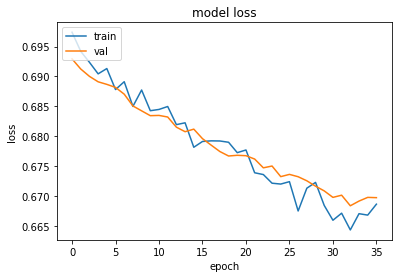

In [10]:
#params={'batch_size': 8, 'epochs': 40, 'learning_rate': 9.509560981225496e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
model1 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.LeakyReLU(alpha=0.3),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.LeakyReLU(alpha=0.3),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
    ])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
model1.compile(optimizer=SGD(lr=9.509560981225496e-05), loss='categorical_crossentropy', metrics=['accuracy'])
H = model1.fit(train_generator,batch_size=8,callbacks=[callback],
        epochs=40,validation_data=test_generator,shuffle=True)

plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Model 2

In [ ]:
model2 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='sigmoid', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(32, (3,3), activation='sigmoid'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(64, (3,3), activation='sigmoid'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(128, (3,3), activation='sigmoid'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(256, (3,3), activation='sigmoid'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(128, activation="sigmoid"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(NUM_CLASSES, activation="sigmoid")
    ])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.

model2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"])

history = model2.fit(train_generator,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=test_generator,
                      callbacks=[callback],
                      shuffle=True)

Epoch 1/100
50/50 [==============================] - 11s 205ms/step - loss: 2.5191 - accuracy: 0.4925 - val_loss: 1.0666 - val_accuracy: 0.5000
Epoch 2/100
50/50 [==============================] - 10s 197ms/step - loss: 0.7470 - accuracy: 0.5050 - val_loss: 0.6991 - val_accuracy: 0.5000
Epoch 3/100
50/50 [==============================] - 10s 200ms/step - loss: 0.7153 - accuracy: 0.4719 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 4/100
50/50 [==============================] - 10s 200ms/step - loss: 0.7122 - accuracy: 0.4938 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/100
50/50 [==============================] - 11s 218ms/step - loss: 0.7148 - accuracy: 0.4837 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/100
50/50 [==============================] - 10s 199ms/step - loss: 0.7085 - accuracy: 0.4800 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 7/100
50/50 [==============================] - 10s 199ms/step - loss: 0.7014 - accuracy: 0.4950 - val_loss: 0.6932 - val_accuracy:

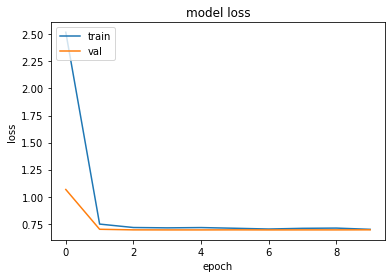

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

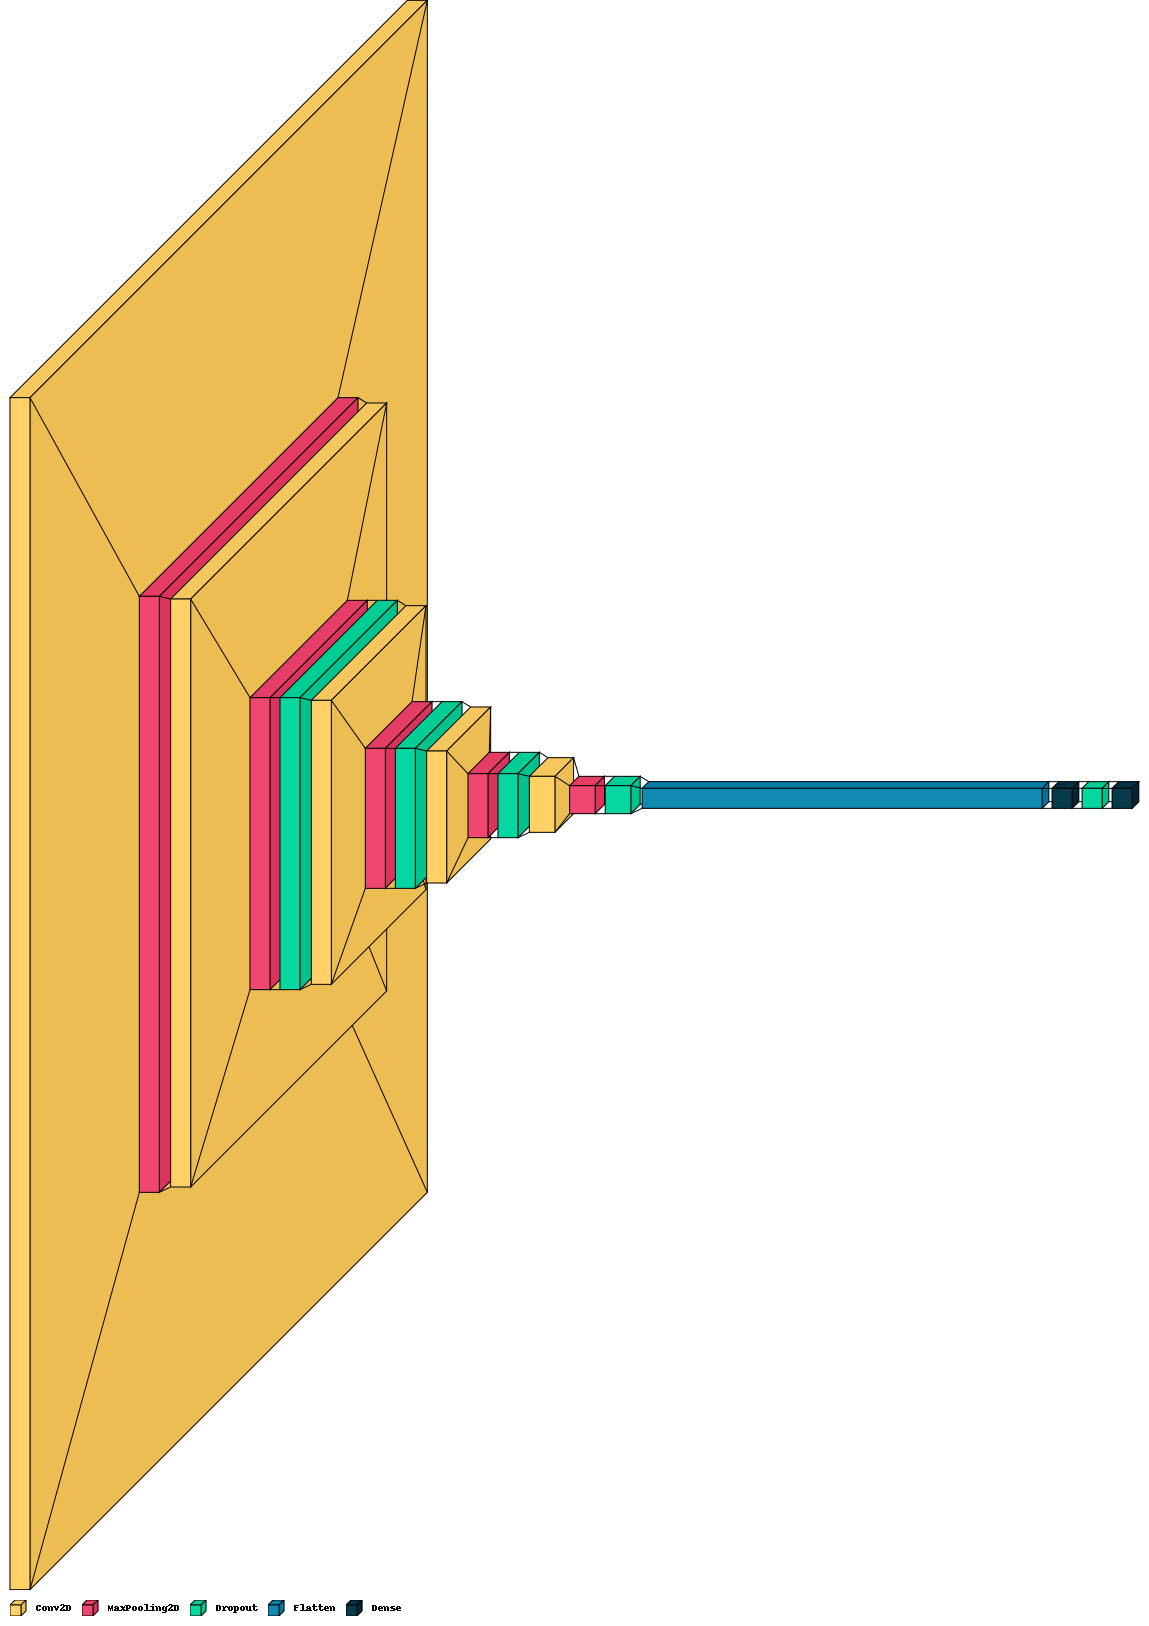

In [ ]:
visualkeras.layered_view(model2,legend=True, draw_volume=True)

## 5 Fold Cross Validation with Optuna (Model 2)

In [ ]:
n_train_iter = 1
def objective(trial):
    # Parameters
    batch_size = trial.suggest_int("batch_size", 2, 8, step=2)
    epochs = trial.suggest_int("epochs", 10,50, step=10)
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    opt = trial.suggest_categorical("optimizer", [Adam, SGD, RMSprop])

    # Model
    model2 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='sigmoid', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(32, (3,3), activation='sigmoid'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(64, (3,3), activation='sigmoid'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(128, (3,3), activation='sigmoid'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(256, (3,3), activation='sigmoid'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(128, activation="sigmoid"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(NUM_CLASSES, activation="sigmoid")
    ])
    for step in range(n_train_iter):
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
        model2.compile(optimizer=opt(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
        H = model2.fit(train_generator,batch_size=batch_size,callbacks=[callback],
                epochs=epochs,validation_data=test_generator,shuffle=True)
        
        val_loss, val_acc = model2.evaluate(test_generator)
        trial.report(val_acc, step)

        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return val_loss # optuna değerlendirmesini en küçük değere göre yapıyor o yüzden loss döndürdüm. Accuracy döndürdüğümde acc büyüdükçe bunu kötü bir şeymiş gibi algıladı.


# Default Sampler is Tree-structured Parzen Estimator algorithm

study = optuna.create_study()  # Create a new study.
start = time.time()
study.optimize(objective, n_trials=5)
end = time.time()

[I 2022-12-25 12:01:48,691] A new study created in memory with name: no-name-2ee264de-a389-4899-a183-620870373059


Epoch 1/40
50/50 [==============================] - 11s 208ms/step - loss: 1.1187 - accuracy: 0.4906 - val_loss: 0.6960 - val_accuracy: 0.5000
Epoch 2/40
50/50 [==============================] - 10s 201ms/step - loss: 0.7261 - accuracy: 0.5031 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/40
50/50 [==============================] - 10s 202ms/step - loss: 0.7340 - accuracy: 0.4931 - val_loss: 0.7026 - val_accuracy: 0.5000
Epoch 4/40
50/50 [==============================] - 10s 200ms/step - loss: 0.7192 - accuracy: 0.5000 - val_loss: 0.7031 - val_accuracy: 0.5000
Epoch 5/40
13/13 [==============================] - 2s 145ms/step - loss: 0.6998 - accuracy: 0.5000


[I 2022-12-25 12:02:43,361] Trial 0 finished with value: 0.6997938752174377 and parameters: {'batch_size': 4, 'epochs': 40, 'learning_rate': 0.005711441948070854, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>}. Best is trial 0 with value: 0.6997938752174377.


Epoch 1/30
50/50 [==============================] - 11s 207ms/step - loss: 0.7735 - accuracy: 0.5019 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/30
50/50 [==============================] - 10s 202ms/step - loss: 0.7249 - accuracy: 0.5244 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/30
50/50 [==============================] - 10s 201ms/step - loss: 0.7437 - accuracy: 0.5050 - val_loss: 0.7074 - val_accuracy: 0.5000
Epoch 4/30
50/50 [==============================] - 11s 218ms/step - loss: 0.7329 - accuracy: 0.5044 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/30
50/50 [==============================] - 10s 201ms/step - loss: 0.7393 - accuracy: 0.4906 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 6/30
50/50 [==============================] - 10s 200ms/step - loss: 0.7263 - accuracy: 0.4975 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 7/30
13/13 [==============================] - 2s 145ms/step - loss: 0.6956 - accuracy: 0.5000


[I 2022-12-25 12:03:58,299] Trial 1 finished with value: 0.6955534219741821 and parameters: {'batch_size': 4, 'epochs': 30, 'learning_rate': 0.0006549291919194616, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>}. Best is trial 1 with value: 0.6955534219741821.


Epoch 1/40
50/50 [==============================] - 11s 208ms/step - loss: 0.7727 - accuracy: 0.4950 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/40
50/50 [==============================] - 10s 202ms/step - loss: 0.7337 - accuracy: 0.5038 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 3/40
50/50 [==============================] - 10s 199ms/step - loss: 0.7322 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/40
13/13 [==============================] - 2s 146ms/step - loss: 0.6939 - accuracy: 0.5000


[I 2022-12-25 12:04:41,873] Trial 2 finished with value: 0.6938936710357666 and parameters: {'batch_size': 4, 'epochs': 40, 'learning_rate': 0.00023349702045759413, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}. Best is trial 2 with value: 0.6938936710357666.


Epoch 1/40
50/50 [==============================] - 11s 207ms/step - loss: 2.1901 - accuracy: 0.5038 - val_loss: 0.9160 - val_accuracy: 0.5000
Epoch 2/40
50/50 [==============================] - 10s 202ms/step - loss: 0.7425 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/40
50/50 [==============================] - 10s 202ms/step - loss: 0.7102 - accuracy: 0.5038 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 4/40
50/50 [==============================] - 10s 202ms/step - loss: 0.7093 - accuracy: 0.4825 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 5/40
50/50 [==============================] - 10s 202ms/step - loss: 0.7066 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/40
50/50 [==============================] - 10s 201ms/step - loss: 0.7076 - accuracy: 0.4925 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 7/40
50/50 [==============================] - 11s 212ms/step - loss: 0.7091 - accuracy: 0.4894 - val_loss: 0.6931 - val_accuracy: 0.5000

[I 2022-12-25 12:06:27,400] Trial 3 finished with value: 0.6935204863548279 and parameters: {'batch_size': 6, 'epochs': 40, 'learning_rate': 0.0010805685887489704, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}. Best is trial 3 with value: 0.6935204863548279.


Epoch 1/40
50/50 [==============================] - 17s 207ms/step - loss: 0.7469 - accuracy: 0.5138 - val_loss: 0.7004 - val_accuracy: 0.5000
Epoch 2/40
50/50 [==============================] - 10s 202ms/step - loss: 0.7322 - accuracy: 0.4881 - val_loss: 0.6955 - val_accuracy: 0.5000
Epoch 3/40
50/50 [==============================] - 10s 202ms/step - loss: 0.7242 - accuracy: 0.4794 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 4/40
50/50 [==============================] - 10s 206ms/step - loss: 0.7099 - accuracy: 0.4888 - val_loss: 0.7083 - val_accuracy: 0.5000
Epoch 5/40
50/50 [==============================] - 10s 202ms/step - loss: 0.7086 - accuracy: 0.5125 - val_loss: 0.6963 - val_accuracy: 0.5000
Epoch 6/40
13/13 [==============================] - 2s 149ms/step - loss: 0.6947 - accuracy: 0.5000


[I 2022-12-25 12:07:37,474] Trial 4 finished with value: 0.6946933269500732 and parameters: {'batch_size': 6, 'epochs': 40, 'learning_rate': 0.004466534160160097, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}. Best is trial 3 with value: 0.6935204863548279.


In [ ]:
study.best_trial

FrozenTrial(number=3, values=[0.6935204863548279], datetime_start=datetime.datetime(2022, 12, 25, 12, 4, 41, 874734), datetime_complete=datetime.datetime(2022, 12, 25, 12, 6, 27, 400629), params={'batch_size': 6, 'epochs': 40, 'learning_rate': 0.0010805685887489704, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}, distributions={'batch_size': IntDistribution(high=8, log=False, low=2, step=2), 'epochs': IntDistribution(high=50, log=False, low=10, step=10), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'optimizer': CategoricalDistribution(choices=(<class 'keras.optimizers.optimizer_v2.adam.Adam'>, <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>, <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>))}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.5}, trial_id=3, state=TrialState.COMPLETE, value=None)

Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


50/50 [==============================] - 13s 237ms/step - loss: 2.1529 - accuracy: 0.5056 - val_loss: 0.7499 - val_accuracy: 0.5000
Epoch 2/40
50/50 [==============================] - 10s 204ms/step - loss: 0.7276 - accuracy: 0.5019 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 3/40
50/50 [==============================] - 10s 207ms/step - loss: 0.7056 - accuracy: 0.5181 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 4/40
50/50 [==============================] - 10s 205ms/step - loss: 0.7090 - accuracy: 0.5200 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/40
50/50 [==============================] - 10s 205ms/step - loss: 0.7062 - accuracy: 0.5194 - val_loss: 0.6995 - val_accuracy: 0.5000
Epoch 6/40
50/50 [==============================] - 10s 207ms/step - loss: 0.7115 - accuracy: 0.4975 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 7/40
50/50 [==============================] - 11s 228ms/step - loss: 0.7192 - accuracy: 0.5000 - val_loss: 0.6941 - val_accuracy: 0.5000


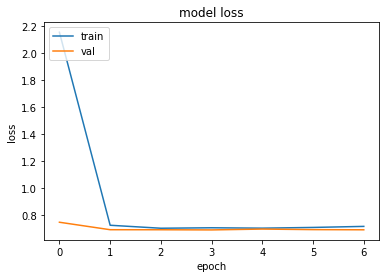

In [11]:
#{'batch_size': 6, 'epochs': 40, 'learning_rate': 0.0010805685887489704, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}
model2 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='sigmoid', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(32, (3,3), activation='sigmoid'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(64, (3,3), activation='sigmoid'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(128, (3,3), activation='sigmoid'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(256, (3,3), activation='sigmoid'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(128, activation="sigmoid"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(NUM_CLASSES, activation="sigmoid")
    ])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
model2.compile(optimizer=Adam(lr=0.0010805685887489704), loss='categorical_crossentropy', metrics=['accuracy'])
H = model2.fit(train_generator,batch_size=6,callbacks=[callback],
        epochs=40,validation_data=test_generator,shuffle=True)

plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Model 3

In [ ]:

model3 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2), 

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2), 

        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
    ])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode='min' )
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.

model3.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"])

history = model3.fit(train_generator,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=test_generator,
                      callbacks=[callback],
                      shuffle=True)

Epoch 1/100
50/50 [==============================] - 11s 206ms/step - loss: 0.6935 - accuracy: 0.5044 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 2/100
50/50 [==============================] - 10s 199ms/step - loss: 0.6852 - accuracy: 0.5881 - val_loss: 0.6753 - val_accuracy: 0.5650
Epoch 3/100
50/50 [==============================] - 10s 202ms/step - loss: 0.6772 - accuracy: 0.5775 - val_loss: 0.6645 - val_accuracy: 0.5875
Epoch 4/100
50/50 [==============================] - 10s 201ms/step - loss: 0.6457 - accuracy: 0.6394 - val_loss: 0.6386 - val_accuracy: 0.6400
Epoch 5/100
50/50 [==============================] - 11s 219ms/step - loss: 0.6383 - accuracy: 0.6256 - val_loss: 0.6634 - val_accuracy: 0.6200
Epoch 6/100
50/50 [==============================] - 10s 201ms/step - loss: 0.6104 - accuracy: 0.6587 - val_loss: 0.6328 - val_accuracy: 0.6225
Epoch 7/100
50/50 [==============================] - 10s 198ms/step - loss: 0.5878 - accuracy: 0.6737 - val_loss: 0.6300 - val_accuracy:

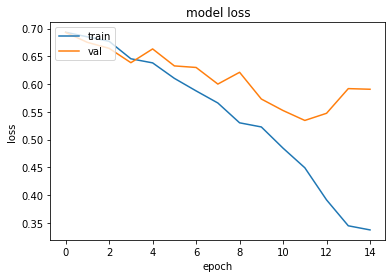

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

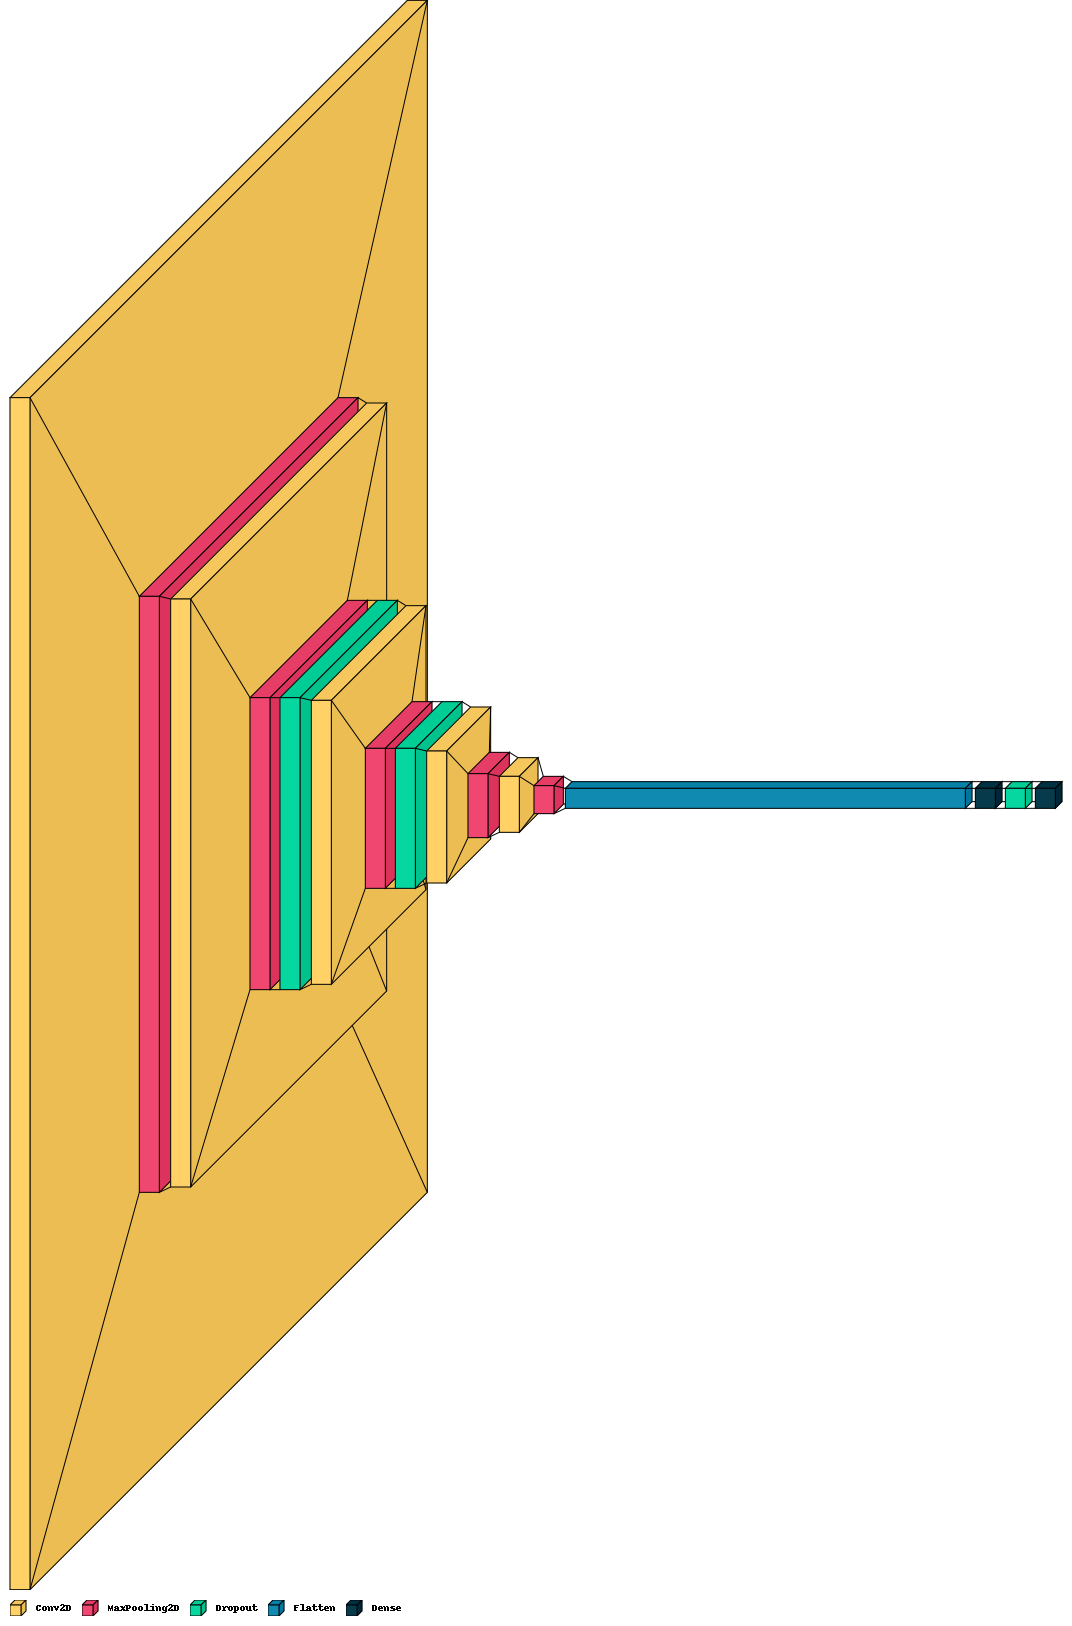

In [ ]:
visualkeras.layered_view(model3,legend=True, draw_volume=True)

## 5 Fold Cross Validation with Optuna (Model 3)

In [ ]:
n_train_iter = 1
def objective(trial):
    # Parameters
    batch_size = trial.suggest_int("batch_size", 2, 8, step=2)
    epochs = trial.suggest_int("epochs", 10,50, step=10)
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    opt = trial.suggest_categorical("optimizer", [Adam, SGD, RMSprop])

    # Model
    model3 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2), 

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2), 

        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
    ])
    for step in range(n_train_iter):
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
        model3.compile(optimizer=opt(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
        H = model3.fit(train_generator,batch_size=batch_size,callbacks=[callback],
                epochs=epochs,validation_data=test_generator,shuffle=True)
        
        val_loss, val_acc = model3.evaluate(test_generator)
        trial.report(val_acc, step)

        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return val_loss # optuna değerlendirmesini en küçük değere göre yapıyor o yüzden loss döndürdüm. Accuracy döndürdüğümde acc büyüdükçe bunu kötü bir şeymiş gibi algıladı.


# Default Sampler is Tree-structured Parzen Estimator algorithm

study = optuna.create_study()  # Create a new study.
start = time.time()
study.optimize(objective, n_trials=5)
end = time.time()

[I 2022-12-25 12:10:10,837] A new study created in memory with name: no-name-4733295c-4fd2-438f-8f78-7e783f0cb0a0


Epoch 1/30
50/50 [==============================] - 11s 206ms/step - loss: 0.7000 - accuracy: 0.4863 - val_loss: 0.6948 - val_accuracy: 0.5000
Epoch 2/30
50/50 [==============================] - 10s 200ms/step - loss: 0.7013 - accuracy: 0.4844 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 3/30
50/50 [==============================] - 10s 201ms/step - loss: 0.7003 - accuracy: 0.4688 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 4/30
50/50 [==============================] - 10s 199ms/step - loss: 0.6994 - accuracy: 0.4775 - val_loss: 0.6943 - val_accuracy: 0.5025
Epoch 5/30
50/50 [==============================] - 11s 220ms/step - loss: 0.6994 - accuracy: 0.4881 - val_loss: 0.6942 - val_accuracy: 0.5075
Epoch 6/30
50/50 [==============================] - 10s 201ms/step - loss: 0.6957 - accuracy: 0.4988 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 7/30
50/50 [==============================] - 10s 200ms/step - loss: 0.6977 - accuracy: 0.4844 - val_loss: 0.6940 - val_accuracy: 0.5050

[I 2022-12-25 12:15:17,869] Trial 0 finished with value: 0.6927986145019531 and parameters: {'batch_size': 6, 'epochs': 30, 'learning_rate': 5.739882783710739e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}. Best is trial 0 with value: 0.6927986145019531.


Epoch 1/10
50/50 [==============================] - 11s 205ms/step - loss: 0.6935 - accuracy: 0.5119 - val_loss: 0.6918 - val_accuracy: 0.5075
Epoch 2/10
50/50 [==============================] - 10s 198ms/step - loss: 0.6908 - accuracy: 0.5200 - val_loss: 0.6921 - val_accuracy: 0.5200
Epoch 3/10
50/50 [==============================] - 10s 199ms/step - loss: 0.6897 - accuracy: 0.5444 - val_loss: 0.6914 - val_accuracy: 0.5525
Epoch 4/10
50/50 [==============================] - 10s 209ms/step - loss: 0.6889 - accuracy: 0.5381 - val_loss: 0.6914 - val_accuracy: 0.5050
Epoch 5/10
50/50 [==============================] - 10s 204ms/step - loss: 0.6872 - accuracy: 0.5506 - val_loss: 0.6913 - val_accuracy: 0.4975
Epoch 6/10
50/50 [==============================] - 10s 199ms/step - loss: 0.6866 - accuracy: 0.5238 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 7/10
50/50 [==============================] - 10s 199ms/step - loss: 0.6858 - accuracy: 0.5594 - val_loss: 0.6894 - val_accuracy: 0.5475

[I 2022-12-25 12:17:01,751] Trial 1 finished with value: 0.6883586645126343 and parameters: {'batch_size': 4, 'epochs': 10, 'learning_rate': 0.005903049554604443, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}. Best is trial 1 with value: 0.6883586645126343.


Epoch 1/30
50/50 [==============================] - 11s 205ms/step - loss: 0.6971 - accuracy: 0.5088 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 2/30
50/50 [==============================] - 10s 199ms/step - loss: 0.6922 - accuracy: 0.5094 - val_loss: 0.6918 - val_accuracy: 0.5800
Epoch 3/30
50/50 [==============================] - 10s 203ms/step - loss: 0.6898 - accuracy: 0.5525 - val_loss: 0.6869 - val_accuracy: 0.5900
Epoch 4/30
50/50 [==============================] - 10s 201ms/step - loss: 0.6817 - accuracy: 0.5575 - val_loss: 0.6864 - val_accuracy: 0.5350
Epoch 5/30
50/50 [==============================] - 10s 199ms/step - loss: 0.6585 - accuracy: 0.6044 - val_loss: 0.6598 - val_accuracy: 0.6100
Epoch 6/30
50/50 [==============================] - 10s 198ms/step - loss: 0.6438 - accuracy: 0.6212 - val_loss: 0.6428 - val_accuracy: 0.6225
Epoch 7/30
50/50 [==============================] - 10s 198ms/step - loss: 0.6164 - accuracy: 0.6669 - val_loss: 0.6366 - val_accuracy: 0.6450

[I 2022-12-25 12:19:16,243] Trial 2 finished with value: 0.5891382098197937 and parameters: {'batch_size': 4, 'epochs': 30, 'learning_rate': 0.00041100701877066267, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}. Best is trial 2 with value: 0.5891382098197937.


Epoch 1/30
50/50 [==============================] - 11s 205ms/step - loss: 0.7092 - accuracy: 0.5150 - val_loss: 0.6963 - val_accuracy: 0.5000
Epoch 2/30
50/50 [==============================] - 10s 198ms/step - loss: 0.7043 - accuracy: 0.4725 - val_loss: 0.6949 - val_accuracy: 0.4900
Epoch 3/30
50/50 [==============================] - 10s 198ms/step - loss: 0.7039 - accuracy: 0.4913 - val_loss: 0.6945 - val_accuracy: 0.5075
Epoch 4/30
50/50 [==============================] - 10s 198ms/step - loss: 0.6986 - accuracy: 0.4875 - val_loss: 0.6943 - val_accuracy: 0.4850
Epoch 5/30
50/50 [==============================] - 10s 197ms/step - loss: 0.6982 - accuracy: 0.5031 - val_loss: 0.6941 - val_accuracy: 0.4800
Epoch 6/30
50/50 [==============================] - 10s 199ms/step - loss: 0.6969 - accuracy: 0.5006 - val_loss: 0.6939 - val_accuracy: 0.4800
Epoch 7/30
50/50 [==============================] - 10s 201ms/step - loss: 0.6963 - accuracy: 0.5206 - val_loss: 0.6939 - val_accuracy: 0.4775

[I 2022-12-25 12:24:21,093] Trial 3 finished with value: 0.6920881867408752 and parameters: {'batch_size': 8, 'epochs': 30, 'learning_rate': 0.0001640462363267712, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}. Best is trial 2 with value: 0.5891382098197937.


Epoch 1/40
50/50 [==============================] - 11s 207ms/step - loss: 0.6937 - accuracy: 0.4950 - val_loss: 0.6924 - val_accuracy: 0.4950
Epoch 2/40
50/50 [==============================] - 10s 198ms/step - loss: 0.6922 - accuracy: 0.5213 - val_loss: 0.6919 - val_accuracy: 0.5350
Epoch 3/40
50/50 [==============================] - 10s 198ms/step - loss: 0.6935 - accuracy: 0.5100 - val_loss: 0.6914 - val_accuracy: 0.5325
Epoch 4/40
50/50 [==============================] - 10s 199ms/step - loss: 0.6908 - accuracy: 0.5263 - val_loss: 0.6912 - val_accuracy: 0.5350
Epoch 5/40
50/50 [==============================] - 10s 198ms/step - loss: 0.6889 - accuracy: 0.5331 - val_loss: 0.6905 - val_accuracy: 0.5625
Epoch 6/40
50/50 [==============================] - 10s 198ms/step - loss: 0.6893 - accuracy: 0.5356 - val_loss: 0.6901 - val_accuracy: 0.5625
Epoch 7/40
50/50 [==============================] - 10s 198ms/step - loss: 0.6891 - accuracy: 0.5406 - val_loss: 0.6897 - val_accuracy: 0.5650

[I 2022-12-25 12:28:05,072] Trial 4 finished with value: 0.6837530732154846 and parameters: {'batch_size': 8, 'epochs': 40, 'learning_rate': 0.003757389361335456, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}. Best is trial 2 with value: 0.5891382098197937.


In [ ]:
study.best_trial

FrozenTrial(number=2, values=[0.5891382098197937], datetime_start=datetime.datetime(2022, 12, 25, 12, 17, 1, 752587), datetime_complete=datetime.datetime(2022, 12, 25, 12, 19, 16, 242944), params={'batch_size': 4, 'epochs': 30, 'learning_rate': 0.00041100701877066267, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}, distributions={'batch_size': IntDistribution(high=8, log=False, low=2, step=2), 'epochs': IntDistribution(high=50, log=False, low=10, step=10), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'optimizer': CategoricalDistribution(choices=(<class 'keras.optimizers.optimizer_v2.adam.Adam'>, <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>, <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>))}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.6875}, trial_id=2, state=TrialState.COMPLETE, value=None)

Epoch 1/30
50/50 [==============================] - 12s 224ms/step - loss: 0.6922 - accuracy: 0.5063 - val_loss: 0.6907 - val_accuracy: 0.5625
Epoch 2/30
50/50 [==============================] - 14s 291ms/step - loss: 0.6744 - accuracy: 0.5856 - val_loss: 0.6801 - val_accuracy: 0.5625
Epoch 3/30
50/50 [==============================] - 10s 205ms/step - loss: 0.6517 - accuracy: 0.6162 - val_loss: 0.6619 - val_accuracy: 0.6225
Epoch 4/30
50/50 [==============================] - 11s 217ms/step - loss: 0.6277 - accuracy: 0.6475 - val_loss: 0.6360 - val_accuracy: 0.6375
Epoch 5/30
50/50 [==============================] - 10s 203ms/step - loss: 0.5957 - accuracy: 0.6850 - val_loss: 0.5828 - val_accuracy: 0.6950
Epoch 6/30
50/50 [==============================] - 10s 203ms/step - loss: 0.5610 - accuracy: 0.7100 - val_loss: 0.5782 - val_accuracy: 0.7125
Epoch 7/30
50/50 [==============================] - 10s 208ms/step - loss: 0.5457 - accuracy: 0.7344 - val_loss: 0.5701 - val_accuracy: 0.7175

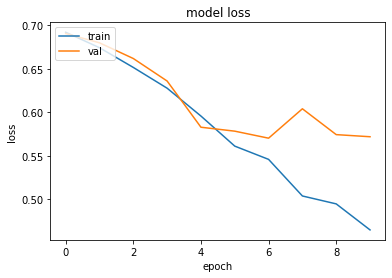

In [13]:
# params={'batch_size': 4, 'epochs': 30, 'learning_rate': 0.00041100701877066267, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}
model3 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2), 

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2), 

        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
    ])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
model3.compile(optimizer=Adam(lr=0.00041100701877066267), loss='categorical_crossentropy', metrics=['accuracy'])
H = model3.fit(train_generator,batch_size=4,callbacks=[callback],
        epochs=30,validation_data=test_generator,shuffle=True)

plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Model 4

In [14]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [ ]:
model = ResNet18(2)
model.build(input_shape = (None,img_height, img_width,3))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"])

history = model.fit(train_generator,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=test_generator,
                      callbacks=[callback],
                      shuffle=True)

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/100
50/50 [==============================] - 15s 249ms/step - loss: 1.0183 - accuracy: 0.5519 - val_loss: 192.5136 - val_accuracy: 0.5000
Epoch 2/100
50/50 [==============================] - 13s 255ms/step - loss: 0.6493 - accuracy: 0.6306 - val_loss: 0.7835 - val_accuracy: 0.5000
Epoch 3/100
50/50 [==============================] - 12s 238ms/step - loss: 0.6323 - accuracy: 0.6444 - val_loss: 0.7038 - val_accuracy: 0.5350
Epoch 4/100
50/50 [==============================] - 12s 238ms/step - loss: 0.6141 - accuracy: 0.6531 - val_loss: 0.8516 - val_accuracy: 0.5025
Epoch 5/100
50/50 [==============================] - 12s 236ms/step - loss: 0.5745 - accuracy: 0.6950 - val_loss: 0.6680 - val_accuracy: 0.6025
Epoch 6/100
50/50 [==============================] - 12s 237ms/step - loss: 0.5767 - accuracy: 0.7119 - val_loss: 1.4847 - val_accuracy: 0.50

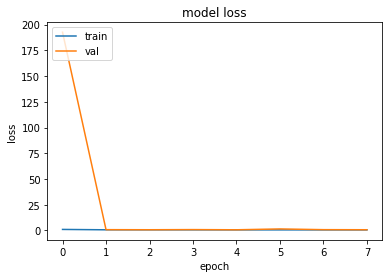

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 5 Fold Cross Validation with Optuna (Model 4)

In [ ]:
n_train_iter = 1
def objective(trial):
    # Parameters
    batch_size = trial.suggest_int("batch_size", 2, 8, step=2)
    epochs = trial.suggest_int("epochs", 10,50, step=10)
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    opt = trial.suggest_categorical("optimizer", [Adam, SGD, RMSprop])

    # Model
    model = ResNet18(2) #class size
    model.build(input_shape = (None,img_height, img_width,3))

    for step in range(n_train_iter):
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
        model3.compile(optimizer=opt(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
        H = model3.fit(train_generator,batch_size=batch_size,callbacks=[callback],
                epochs=epochs,validation_data=test_generator,shuffle=True)
        
        val_loss, val_acc = model3.evaluate(test_generator)
        trial.report(val_acc, step)

        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return val_loss # optuna değerlendirmesini en küçük değere göre yapıyor o yüzden loss döndürdüm. Accuracy döndürdüğümde acc büyüdükçe bunu kötü bir şeymiş gibi algıladı.


# Default Sampler is Tree-structured Parzen Estimator algorithm

study = optuna.create_study()  # Create a new study.
start = time.time()
study.optimize(objective, n_trials=5)
end = time.time()

[I 2022-12-25 12:30:01,601] A new study created in memory with name: no-name-d5fe5dec-840d-473d-9a68-7b80fc563014


Epoch 1/10
50/50 [==============================] - 11s 204ms/step - loss: 0.3609 - accuracy: 0.8269 - val_loss: 0.5894 - val_accuracy: 0.7150
Epoch 2/10
50/50 [==============================] - 10s 196ms/step - loss: 0.2671 - accuracy: 0.8919 - val_loss: 0.5954 - val_accuracy: 0.7200
Epoch 3/10
50/50 [==============================] - 10s 198ms/step - loss: 0.2225 - accuracy: 0.9094 - val_loss: 1.0155 - val_accuracy: 0.6900
Epoch 4/10
13/13 [==============================] - 2s 144ms/step - loss: 0.7871 - accuracy: 0.6950


[I 2022-12-25 12:30:44,637] Trial 0 finished with value: 0.787060558795929 and parameters: {'batch_size': 8, 'epochs': 10, 'learning_rate': 0.00210004628570549, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}. Best is trial 0 with value: 0.787060558795929.


Epoch 1/40
50/50 [==============================] - 11s 216ms/step - loss: 0.2161 - accuracy: 0.9062 - val_loss: 0.7590 - val_accuracy: 0.7200
Epoch 2/40
50/50 [==============================] - 11s 218ms/step - loss: 0.1915 - accuracy: 0.9219 - val_loss: 0.7440 - val_accuracy: 0.7200
Epoch 3/40
50/50 [==============================] - 10s 200ms/step - loss: 0.1871 - accuracy: 0.9212 - val_loss: 0.7360 - val_accuracy: 0.7075
Epoch 4/40
50/50 [==============================] - 10s 199ms/step - loss: 0.1933 - accuracy: 0.9169 - val_loss: 0.7294 - val_accuracy: 0.7150
Epoch 5/40
50/50 [==============================] - 10s 200ms/step - loss: 0.1802 - accuracy: 0.9319 - val_loss: 0.7270 - val_accuracy: 0.7100
Epoch 6/40
50/50 [==============================] - 10s 198ms/step - loss: 0.1792 - accuracy: 0.9400 - val_loss: 0.7257 - val_accuracy: 0.7075
Epoch 7/40
50/50 [==============================] - 10s 199ms/step - loss: 0.1764 - accuracy: 0.9319 - val_loss: 0.7256 - val_accuracy: 0.7050

[I 2022-12-25 12:32:29,537] Trial 1 finished with value: 0.7272949814796448 and parameters: {'batch_size': 8, 'epochs': 40, 'learning_rate': 9.882937502372152e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}. Best is trial 1 with value: 0.7272949814796448.


Epoch 1/30
50/50 [==============================] - 11s 204ms/step - loss: 0.1388 - accuracy: 0.9425 - val_loss: 0.8089 - val_accuracy: 0.7350
Epoch 2/30
50/50 [==============================] - 10s 199ms/step - loss: 0.0899 - accuracy: 0.9681 - val_loss: 0.9074 - val_accuracy: 0.7500
Epoch 3/30
50/50 [==============================] - 10s 201ms/step - loss: 0.0706 - accuracy: 0.9769 - val_loss: 0.9868 - val_accuracy: 0.7450
Epoch 4/30
13/13 [==============================] - 2s 143ms/step - loss: 1.1093 - accuracy: 0.7450


[I 2022-12-25 12:33:13,534] Trial 2 finished with value: 1.1092941761016846 and parameters: {'batch_size': 6, 'epochs': 30, 'learning_rate': 0.00035135443215579066, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>}. Best is trial 1 with value: 0.7272949814796448.


Epoch 1/20
50/50 [==============================] - 11s 204ms/step - loss: 0.1023 - accuracy: 0.9631 - val_loss: 1.0842 - val_accuracy: 0.7275
Epoch 2/20
50/50 [==============================] - 11s 218ms/step - loss: 0.0829 - accuracy: 0.9725 - val_loss: 0.9253 - val_accuracy: 0.7275
Epoch 3/20
50/50 [==============================] - 10s 197ms/step - loss: 0.0523 - accuracy: 0.9794 - val_loss: 1.1969 - val_accuracy: 0.7300
Epoch 4/20
50/50 [==============================] - 10s 196ms/step - loss: 0.0501 - accuracy: 0.9812 - val_loss: 1.3127 - val_accuracy: 0.7400
Epoch 5/20
13/13 [==============================] - 2s 141ms/step - loss: 1.1409 - accuracy: 0.7500


[I 2022-12-25 12:34:07,510] Trial 3 finished with value: 1.1409077644348145 and parameters: {'batch_size': 2, 'epochs': 20, 'learning_rate': 0.0010398632900686234, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}. Best is trial 1 with value: 0.7272949814796448.


Epoch 1/50
50/50 [==============================] - 11s 202ms/step - loss: 0.0279 - accuracy: 0.9906 - val_loss: 1.2261 - val_accuracy: 0.7575
Epoch 2/50
50/50 [==============================] - 10s 198ms/step - loss: 0.0264 - accuracy: 0.9937 - val_loss: 1.2622 - val_accuracy: 0.7600
Epoch 3/50
50/50 [==============================] - 10s 199ms/step - loss: 0.0220 - accuracy: 0.9969 - val_loss: 1.2971 - val_accuracy: 0.7525
Epoch 4/50
13/13 [==============================] - 2s 145ms/step - loss: 1.3247 - accuracy: 0.7500


[I 2022-12-25 12:34:51,081] Trial 4 finished with value: 1.3247361183166504 and parameters: {'batch_size': 6, 'epochs': 50, 'learning_rate': 3.948065513109135e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>}. Best is trial 1 with value: 0.7272949814796448.


In [ ]:
study.best_trial

FrozenTrial(number=1, values=[0.7272949814796448], datetime_start=datetime.datetime(2022, 12, 25, 12, 30, 44, 641619), datetime_complete=datetime.datetime(2022, 12, 25, 12, 32, 29, 537052), params={'batch_size': 8, 'epochs': 40, 'learning_rate': 9.882937502372152e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}, distributions={'batch_size': IntDistribution(high=8, log=False, low=2, step=2), 'epochs': IntDistribution(high=50, log=False, low=10, step=10), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'optimizer': CategoricalDistribution(choices=(<class 'keras.optimizers.optimizer_v2.adam.Adam'>, <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>, <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>))}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.7024999856948853}, trial_id=1, state=TrialState.COMPLETE, value=None)

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/40
50/50 [==============================] - 11s 209ms/step - loss: 0.4205 - accuracy: 0.8194 - val_loss: 0.5457 - val_accuracy: 0.7175
Epoch 2/40
50/50 [==============================] - 11s 216ms/step - loss: 0.4083 - accuracy: 0.8250 - val_loss: 0.5422 - val_accuracy: 0.7225
Epoch 3/40
50/50 [==============================] - 10s 201ms/step - loss: 0.4023 - accuracy: 0.8206 - val_loss: 0.5400 - val_accuracy: 0.7225
Epoch 4/40
50/50 [==============================] - 10s 201ms/step - loss: 0.4083 - accuracy: 0.8200 - val_loss: 0.5394 - val_accuracy: 0.7225
Epoch 5/40
50/50 [==============================] - 10s 203ms/step - loss: 0.4026 - accuracy: 0.8319 - val_loss: 0.5399 - val_accuracy: 0.7225
Epoch 6/40
50/50 [==============================] - 10s 206ms/step - loss: 0.4083 - accuracy: 0.8138 - val_loss: 0.5390 - val_accuracy: 0.7275
Epoch 7/40
50/50 [==============================] - 10s 205ms/step - loss: 0.4086 - accuracy: 0.8206 - val_loss: 0.5385 - val_accuracy: 0.7250

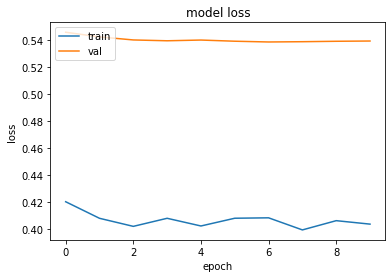

In [15]:
#params={'batch_size': 8, 'epochs': 40, 'learning_rate': 9.882937502372152e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
model = ResNet18(2) #class size
model.build(input_shape = (None,img_height, img_width,3))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
model3.compile(optimizer=SGD(lr=9.882937502372152e-05), loss='categorical_crossentropy', metrics=['accuracy'])
H = model3.fit(train_generator,batch_size=8,callbacks=[callback],
        epochs=40,validation_data=test_generator,shuffle=True)

plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()